In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
import gc
import warnings
from matplotlib import style
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fontdict = {'fontsize':20, 'fontweight':'bold'}

num_list = []
for a in range(2):
    for b in range(2) :
        num_list.append((a,b))

def per_df(data, col1) :
    per_results = data[col1].value_counts() / data[col1].value_counts().sum()
    return per_results   

import kaggleSurvey as pf
ks = pf.KaggleSurvey()

Initializing.
Done.
Tab 키를 이용해서 내부 함수들을 꼭 확인하셔서 같은 작업을 두 번 안하시길.. 화이팅


# 데이터 전처리

In [3]:
# Loading the multiple choices dataset, we will not look to the free form data on this study
mc = pd.read_csv('multipleChoiceResponses.csv', low_memory=False)

# Separating questions from answers
mcQ = mc.iloc[0,:]
mcA = mc.iloc[1:,:]

# removing everyone that took less than 4 minutes or more than 600 minutes to answer the survey
less3 = mcA[round(mcA.iloc[:,0].astype(int) / 60) <= 4].index
mcA = mcA.drop(less3, axis=0)

more300 = mcA[round(mcA.iloc[:,0].astype(int) / 60) >= 600].index
mcA = mcA.drop(more300, axis=0)

# removing gender trolls
gender_trolls = mcA[(mcA.Q1 == 'Prefer to self-describe') | (mcA.Q1 == 'Prefer not to say')].index
mcA = mcA.drop(list(gender_trolls), axis=0)

# removing student trolls
student_trolls = mcA[((mcA.Q6 == 'Student') & (mcA.Q9 > '500,000+')) | \
                     ((mcA.Q6 == 'Student') & (mcA.Q9 > '400-500,000')) | \
                     ((mcA.Q6 == 'Student') & (mcA.Q9 > '300-400,000')) | \
                     ((mcA.Q6 == 'Student') & (mcA.Q9 > '250-300,000'))].index
mcA = mcA.drop(list(student_trolls), axis=0)

# dropping all NaN and I do not wish to disclose my approximate yearly compensation
mcA = mcA[~mcA.Q9.isnull()].copy()
not_disclosed = mcA[mcA.Q9 == 'I do not wish to disclose my approximate yearly compensation'].index
mcA = mcA.drop(list(not_disclosed), axis=0)

#personal data
personal_data = mcA.iloc[:,:13].copy()

cols = ['survey_duration', 'gender', 'gender_text', 'age', 'country', 'education_level', 'undergrad_major', 'role', 'role_text',
        'employer_industry', 'employer_industry_text', 'years_experience', 'yearly_compensation']
personal_data.columns = cols

# Drop text and survey_duration columns 
personal_data.drop(['survey_duration', 'gender_text', 'role_text', 'employer_industry_text'], axis=1, inplace=True)

#Compensation preprocessing
compensation = personal_data.yearly_compensation.str.replace(',', '').str.replace('500000\+', '500-500000').str.split('-')
personal_data['yearly_compensation_numerical'] = compensation.apply(lambda x: (int(x[0]) * 1000 + int(x[1]))/ 2) / 1000 # it is calculated in thousand dollars


#southK = personal_data[personal_data['country']=='South Korea']
#southK.shape

# Top 10 국가 인구 비율 확인

In [4]:
top10_pop = [325719178, 1339180127,1386395000, 144495044, 209288278,82695000,66022273,36708083,67118648, 126785797]
top10 = ['United States of America', 'India', 'China', 'Russia', 'Brazil', 'Germany', 'United Kingdom of Great Britain and Northern Ireland',
 'Canada', 'France', 'Japan'] 
top10_personal = personal_data.loc[personal_data['country'].isin(top10),:]

pop2534 = pd.read_excel('pop25293034.xlsx')
pop2534.index = top10

USA = personal_data[personal_data['country']=='United States of America ']
China = personal_data[personal_data['country']=='China']
India = personal_data[personal_data['country']=='India']

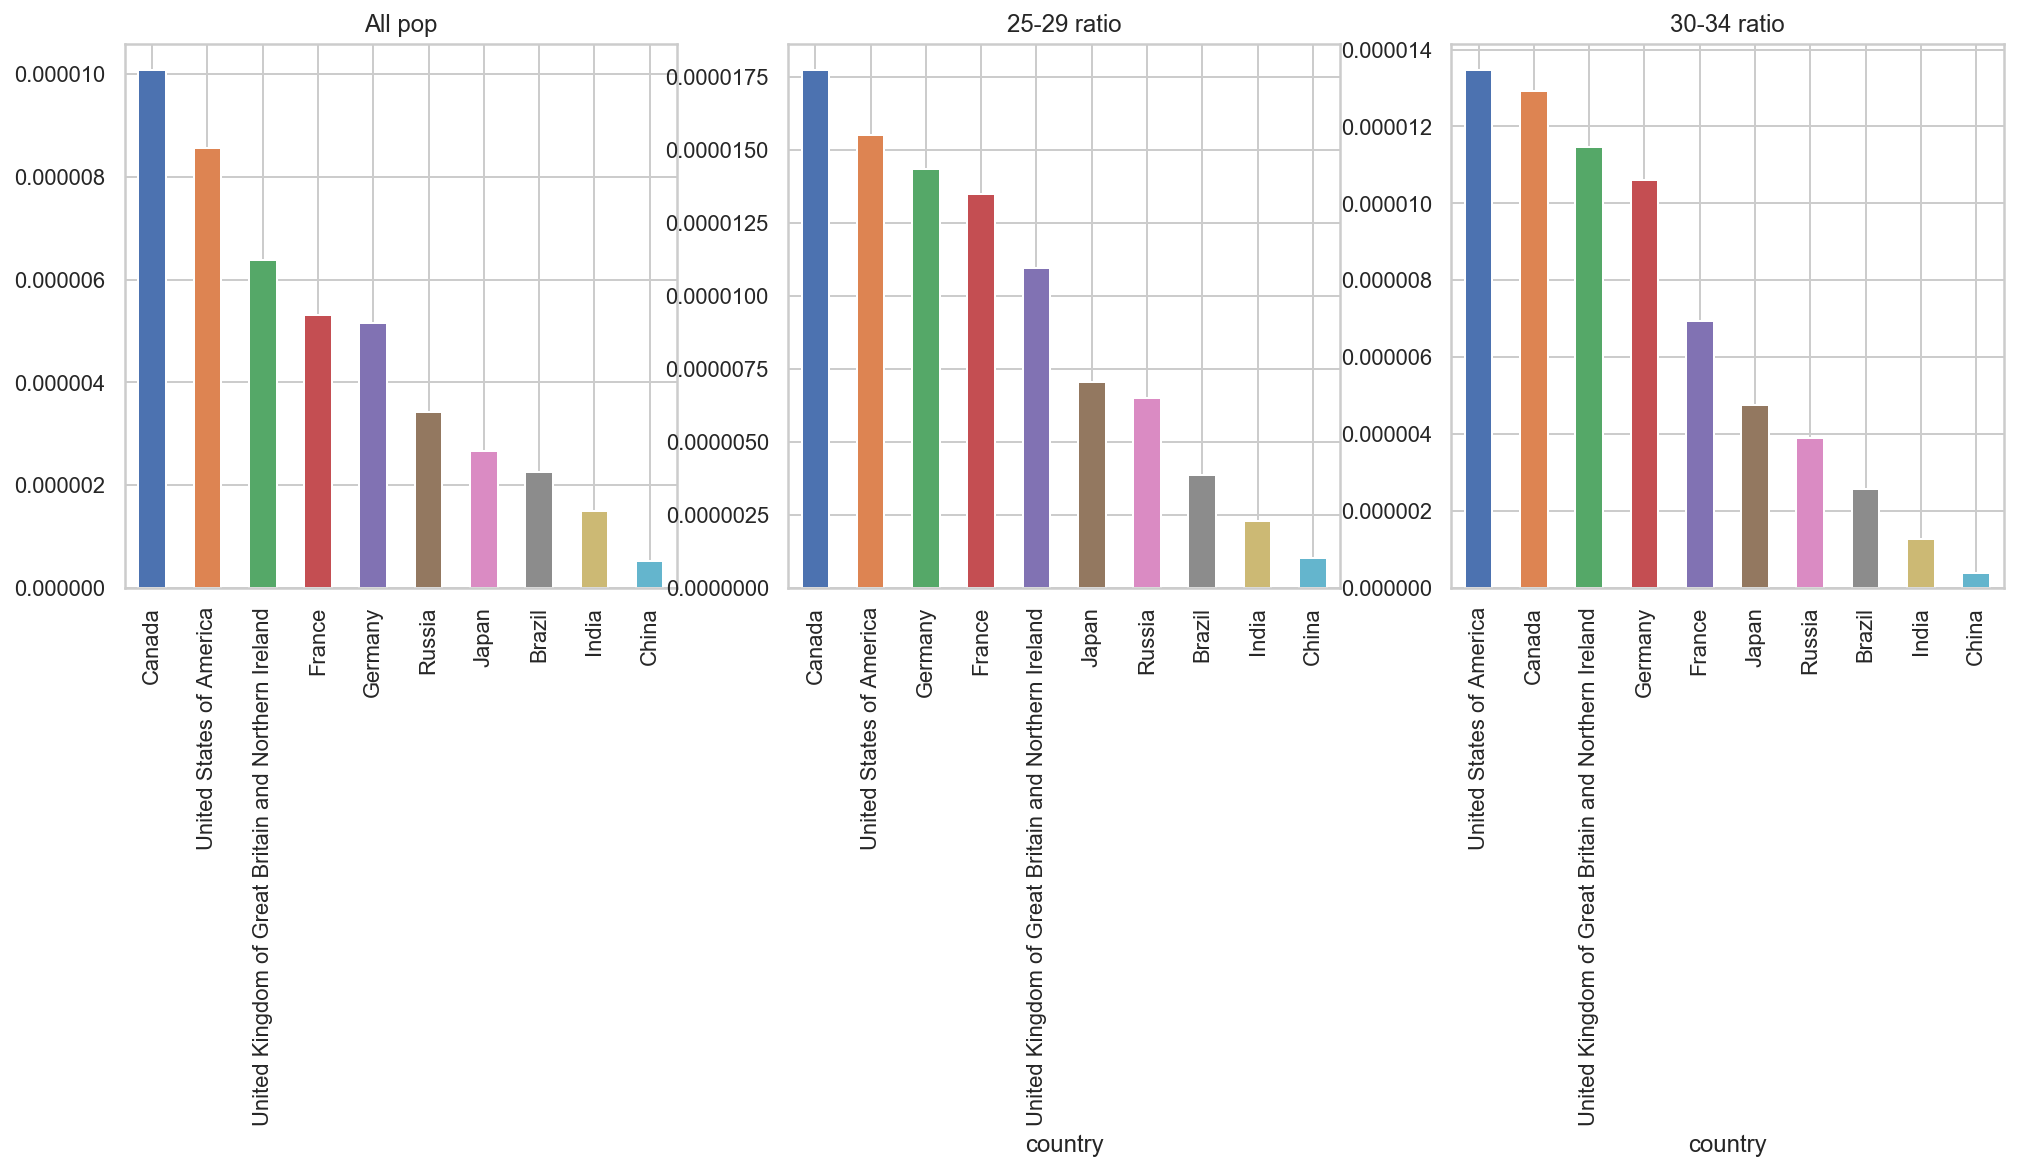

In [29]:
f,ax = plt.subplots(1,3,figsize=(15,5))
(personal_data['country'].value_counts().loc[top10] / top10_pop).sort_values(ascending=False).plot.bar(ax=ax[0], title='All pop')
#ax[0].set_yticklabels(fontsize=10)
(top10_personal.groupby(['country', 'age']).size().unstack('age').loc[top10,'25-29'] / pop2534['pop2529']).sort_values(ascending=False).plot.bar(ax=ax[1], title='25-29 ratio')
#ax[1].set_yticklabels(fontsize=10)
(top10_personal.groupby(['country', 'age']).size().unstack('age').loc[top10,'30-34'] / pop2534['pop3034']).sort_values(ascending=False).plot.bar(ax=ax[2], title='30-34 ratio')
#ax[2].set_yticklabels(fontsize=10)

# 한국 vs 전세계

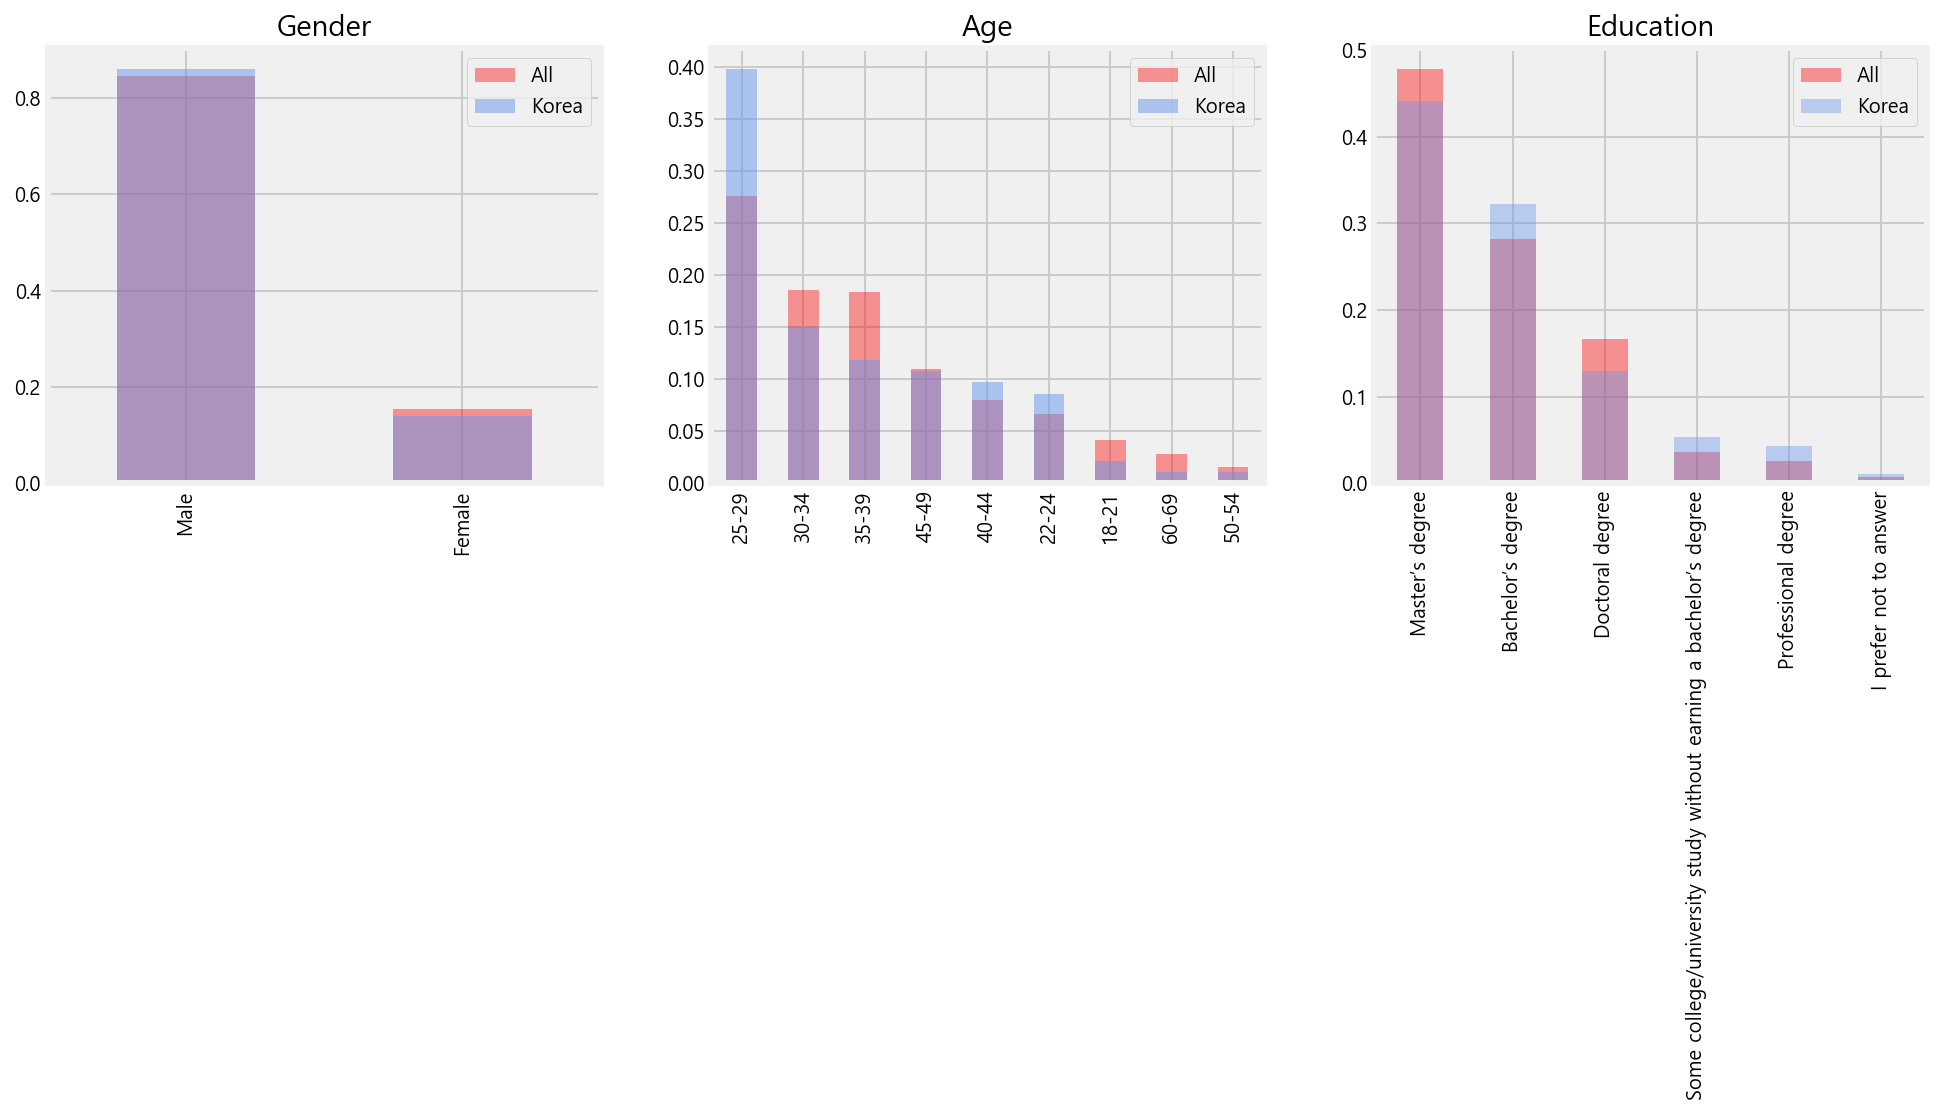

In [31]:
f, ax = plt.subplots(1,3, figsize=(15,4))
per_df(personal_data, 'gender').plot.bar(ax=ax[0], title='Gender', alpha=0.4, color='red')
per_df(southK, 'gender').plot.bar(ax=ax[0], alpha=0.5, color='cornflowerblue')
ax[0].legend(['All', 'Korea'])
per_df(personal_data, 'age').plot.bar(ax=ax[1],title='Age', alpha=0.4, color='red')
per_df(southK, 'age').plot.bar(ax=ax[1], alpha=0.5, color='cornflowerblue')
ax[1].legend(['All', 'Korea'])
per_df(personal_data, 'education_level').plot.bar(ax=ax[2], alpha=0.4, color='red', title='Education')
per_df(southK, 'education_level').plot.bar(ax=ax[2], alpha=0.4, color='cornflowerblue')
ax[2].legend(['All', 'Korea'])

- 한국은 다른 나라들에 비해서, 매우 20대 비율이 높음을 알 수 있음.
- 교육 수준에서는 박사학위는 조금 떨어지고 학사학위는 조금 더 높음.

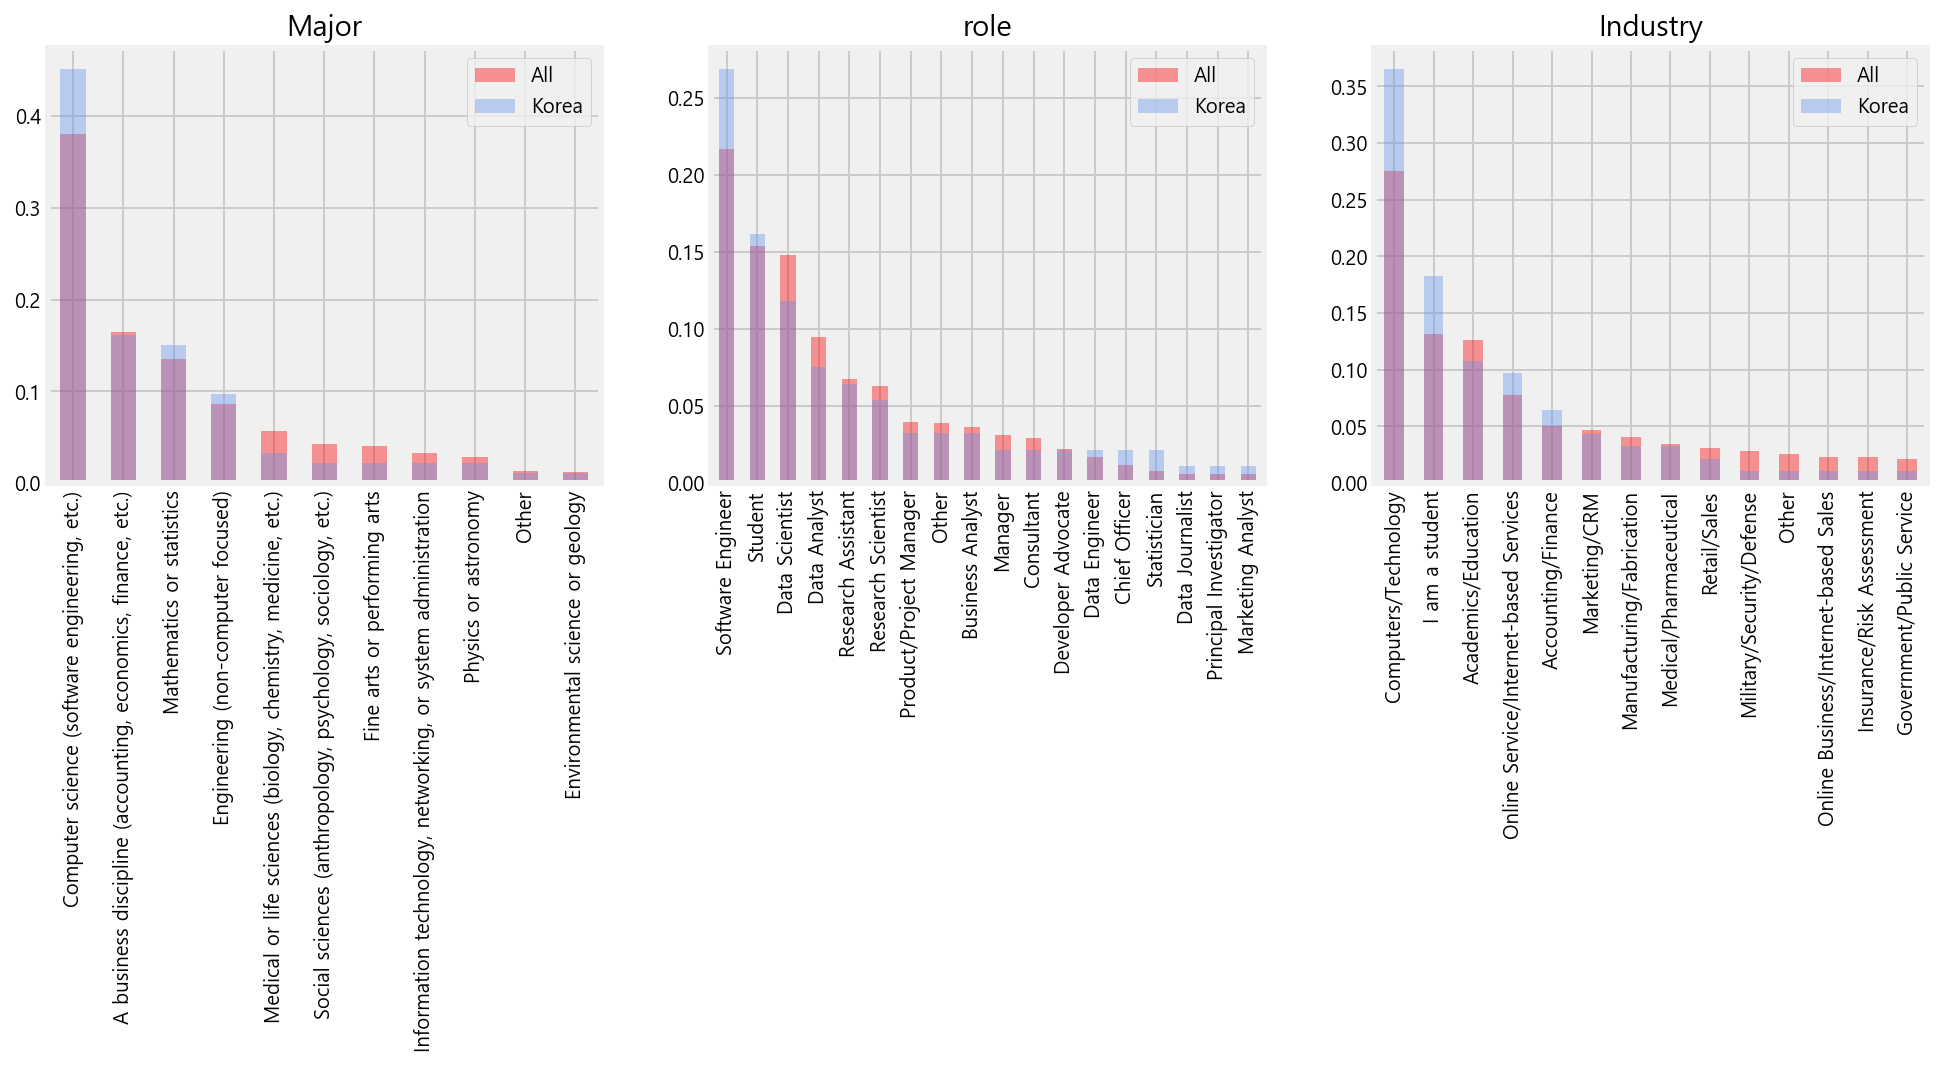

In [41]:
f, ax = plt.subplots(1,3, figsize=(15,4))
per_df(personal_data, 'undergrad_major').plot.bar(ax=ax[0], title='Major', color='red', alpha=0.4)
per_df(southK, 'undergrad_major').plot.bar(ax=ax[0], title='Major', color='cornflowerblue', alpha=0.4)
ax[0].legend(['All', 'Korea'])
per_df(personal_data, 'role').plot.bar(ax=ax[1], title='role', color='red',alpha=0.4)
per_df(southK, 'role').plot.bar(ax=ax[1], title='role', color='cornflowerblue', alpha=0.4)
ax[1].legend(['All', 'Korea'])
per_df(personal_data, 'employer_industry').plot.bar(ax=ax[2], title='Industry', color='red',alpha=0.4)
per_df(southK, 'employer_industry').plot.bar(ax=ax[2], title='Industry', color='cornflowerblue', alpha=0.4)       
ax[2].legend(['All', 'Korea'])


- computer science 전공, software engineer 직업, computer/technology 기업 비율이 전체 평균에 비해 많음을 알 수 있다

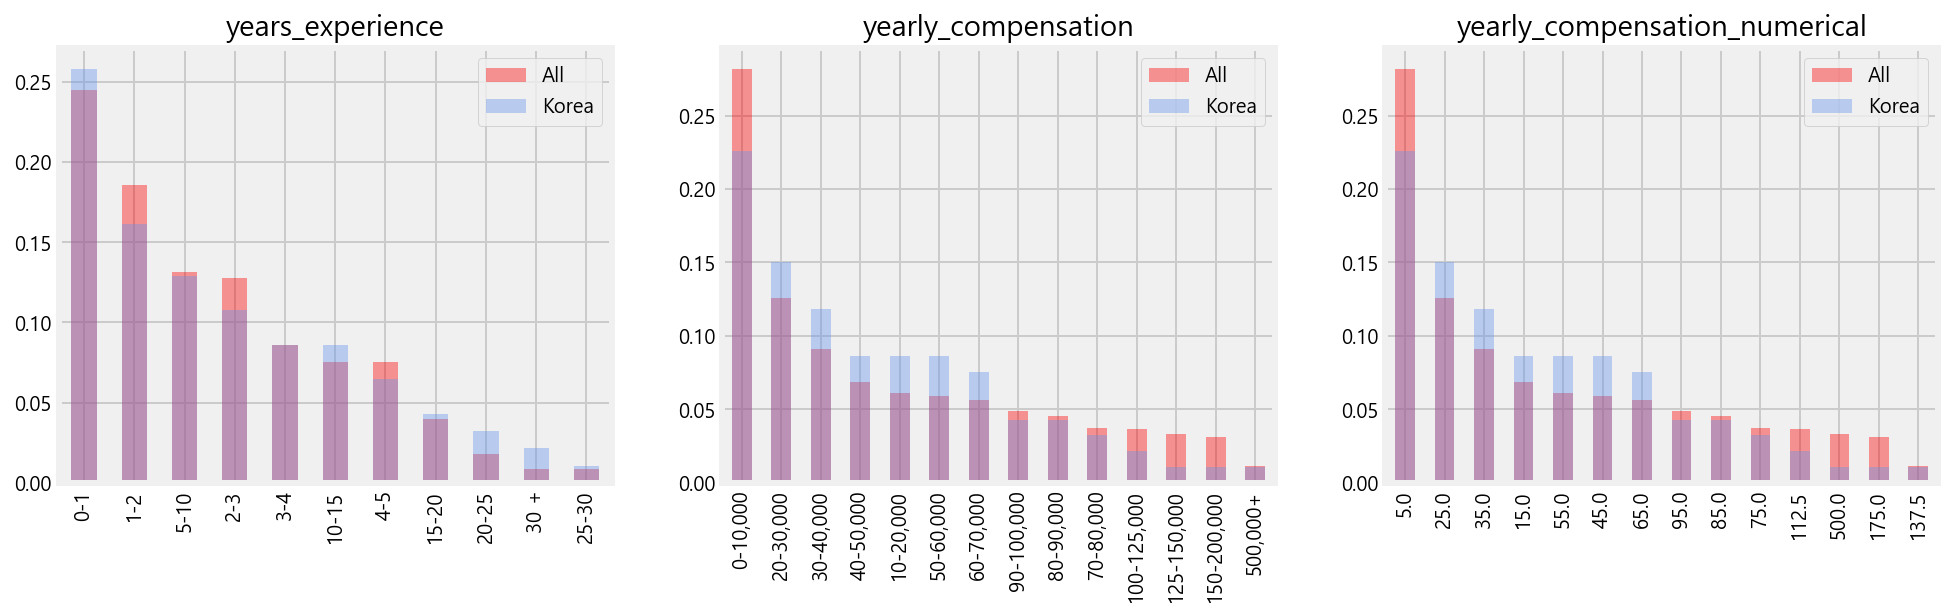

In [61]:
f, ax = plt.subplots(1,3,figsize=(15,4))
for i, n in zip(['years_experience', 'yearly_compensation', 'yearly_compensation_numerical'], range(3)) : 
    per_df(personal_data, i).plot.bar(ax=ax[n], title=i, color='red', alpha=0.4)
    per_df(southK, i).plot.bar(ax=ax[n], title=i, color='cornflowerblue', alpha=0.4)
    ax[n].legend(['All', 'Korea'])


- experience에서는 크게 차이 나는 패턴을 보이지 않으나, compensation에서는 차이가 있음
- 조금 더 25000 이후로 많은 사람들의 비율 존재

In [52]:
southK_induscompen = southK.groupby('employer_industry')[['yearly_compensation_numerical']].mean().sort_values(by='yearly_compensation_numerical',ascending=False)
personal_induscompen = personal_data.groupby('employer_industry')[['yearly_compensation_numerical']].mean().sort_values(by='yearly_compensation_numerical',ascending=False)
all_induscompen = southK_induscompen.merge(personal_induscompen, left_index=True, right_index=True).rename(columns={'yearly_compensation_numerical_x':'Korea', 'yearly_compensation_numerical_y':'All'})

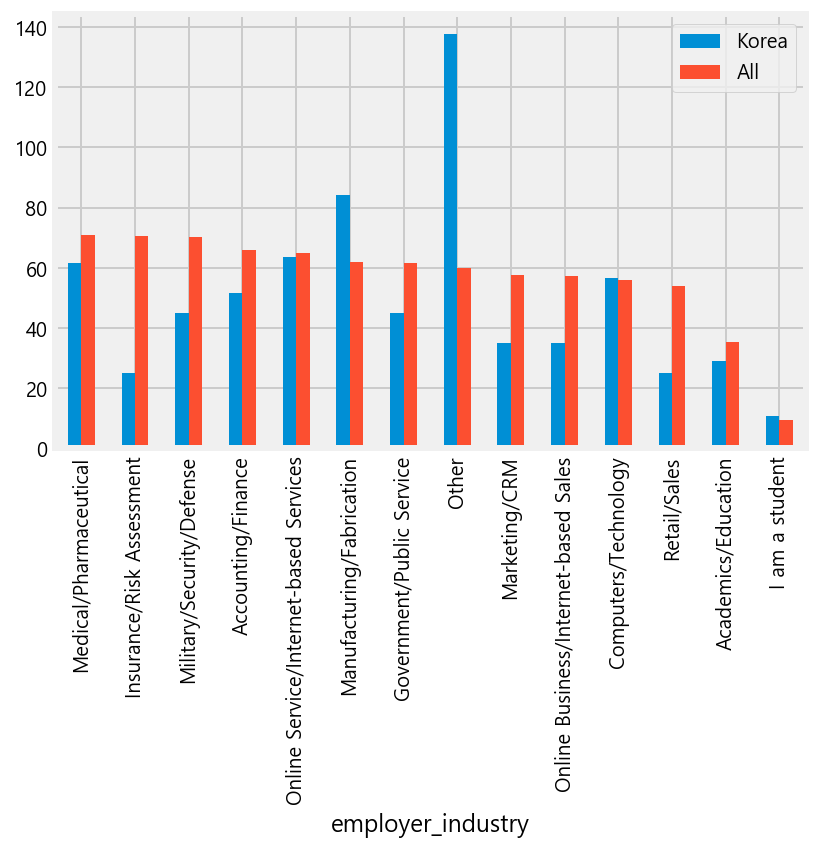

In [58]:
all_induscompen.sort_values(by='All', ascending=False).plot.bar()

- 아주 고른 분포를 보이는 전세계 국가 평균과 달리, 한국은 몇몇 직군에서 강세를 보인다
- Medical, Online Service, Computer 등

# 완전 raw

In [61]:
survey_multi = pd.read_csv('multipleChoiceResponses.csv')
qn_list = survey_multi.iloc[0,:].values.tolist()
survey_multi = survey_multi.iloc[1:, ]

# 질문 리스트 생성
pd.concat([pd.Series(survey_multi.columns), pd.Series(qn_list)],1).to_excel('qn_list.xlsx')

In [67]:
worldbank = pd.read_excel('인구통계_정리본_v2.xlsx')

In [ ]:
plt.scatter(worldbank)

In [68]:
worldbank

,country name,code,GDP,count/pop(%),GNP,POP_total,survey_count
0,United States of America,USA,1.939060e+13,1.447873e-05,59531.661964,325719178,4716
1,India,IND,2.597491e+12,3.298287e-06,1939.612984,1339180127,4417
2,China,CHN,1.223770e+13,1.185809e-06,8826.994096,1386395000,1644
3,Russia,RUS,1.577524e+12,6.083254e-06,10743.096592,144495044,879
4,Brazil,BRA,2.055506e+12,3.516680e-06,9821.407686,209288278,736
5,Germany,DEU,3.677439e+12,8.875990e-06,44469.909061,82695000,734
6,United Kingdom of Great Britain and Northern I...,GBR,2.622434e+12,1.063278e-05,39720.443427,66022273,702
7,Canada,CAN,1.653043e+12,1.645414e-05,45032.119908,36708083,604
8,France,FRA,2.582501e+12,8.998989e-06,38476.658636,67118648,604
9,Japan,JPN,4.872137e+12,4.708729e-06,38428.097317,126785797,597


In [66]:
survey_multi['Q3'].value_counts()[:32]

United States of America                                4716
India                                                   4417
China                                                   1644
Other                                                   1036
Russia                                                   879
Brazil                                                   736
Germany                                                  734
United Kingdom of Great Britain and Northern Ireland     702
Canada                                                   604
France                                                   604
Japan                                                    597
Spain                                                    485
I do not wish to disclose my location                    394
Italy                                                    355
Australia                                                330
Turkey                                                   327
Poland                  

Text(0.5,1,'Age')

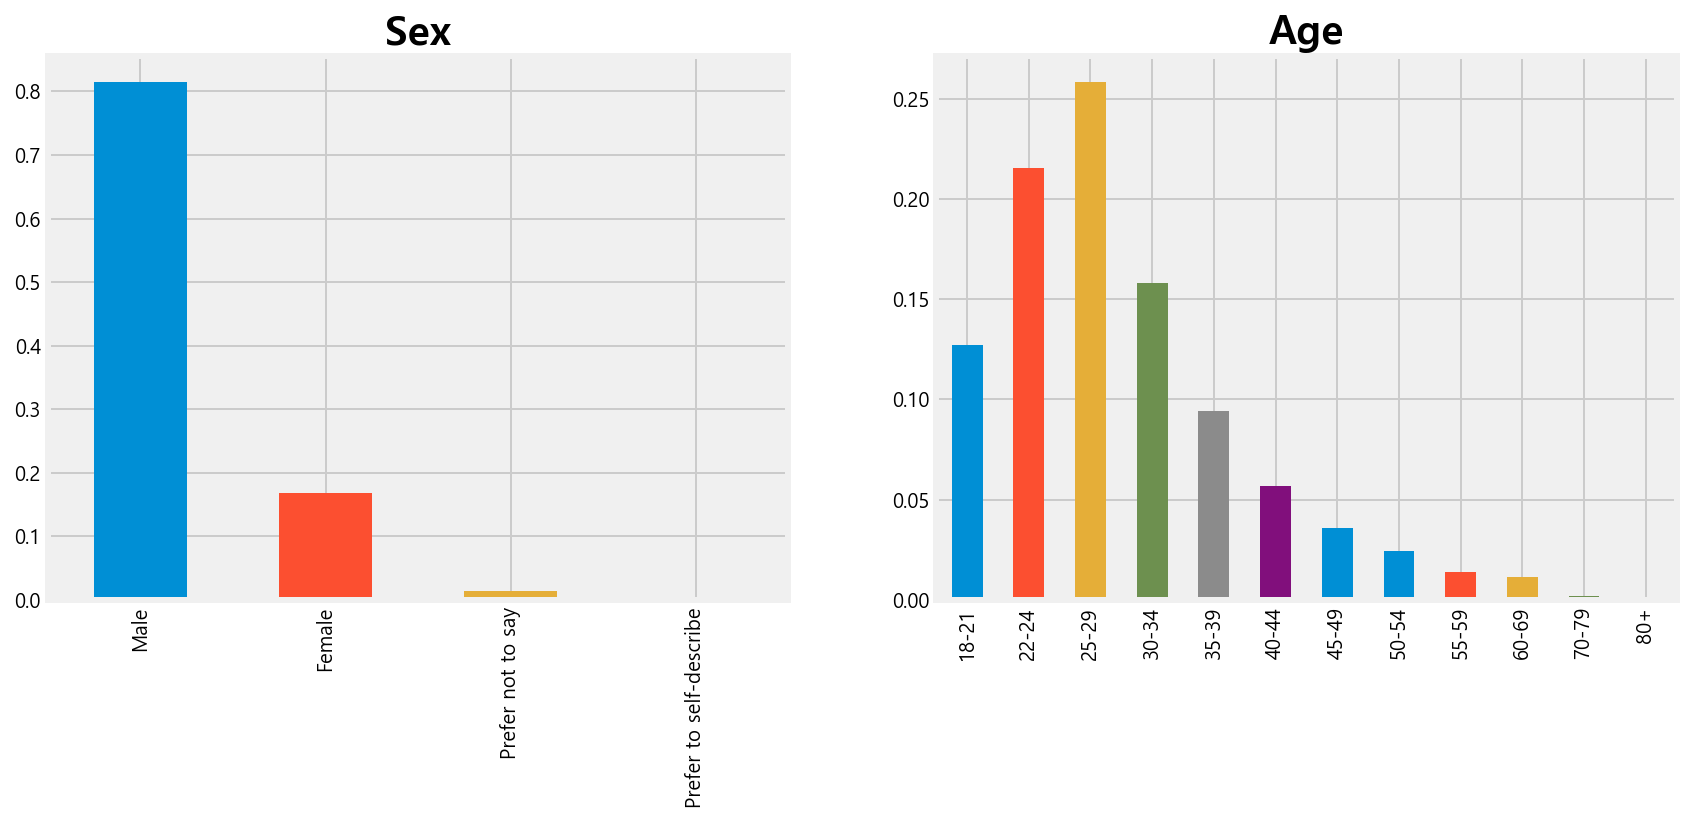

In [6]:
f, ax = plt.subplots(1,2, figsize=(13,5))
per_df('Q1').plot.bar(ax=ax[0]).set_title('Sex', fontdict=fontdict)
per_df('Q2').sort_index().plot.bar(ax=ax[1]).set_title('Age', fontdict=fontdict)

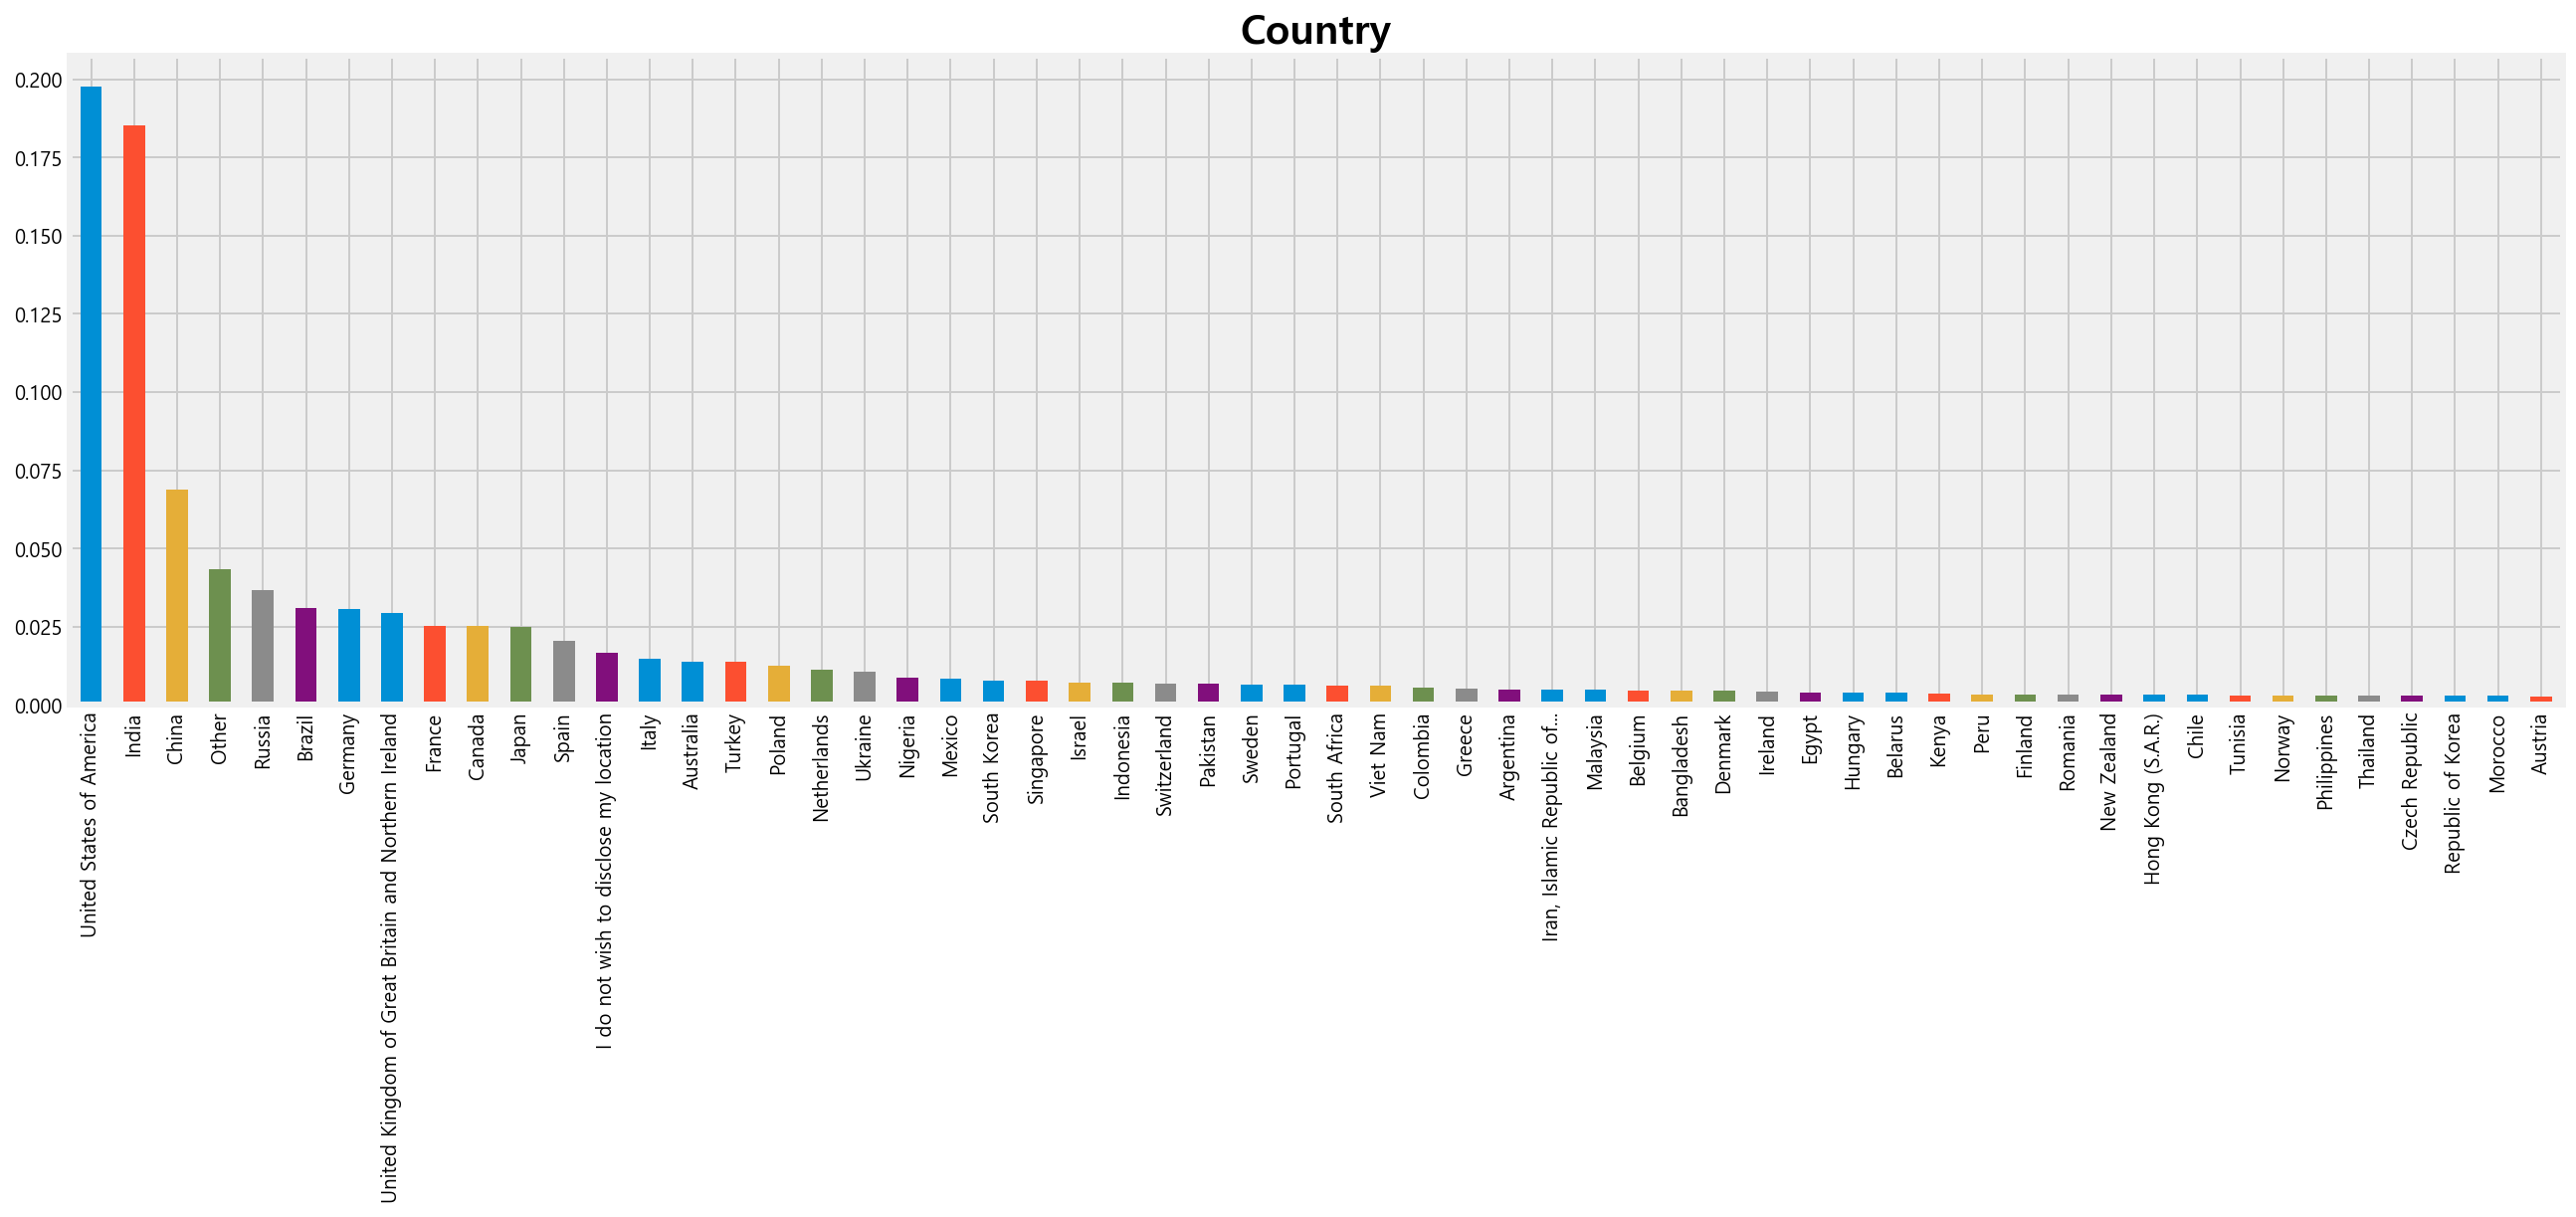

In [7]:
g = per_df('Q3').plot.bar(figsize=(20,6)).set_title('Country', fontdict=fontdict)

Text(0.5,1,'Major')

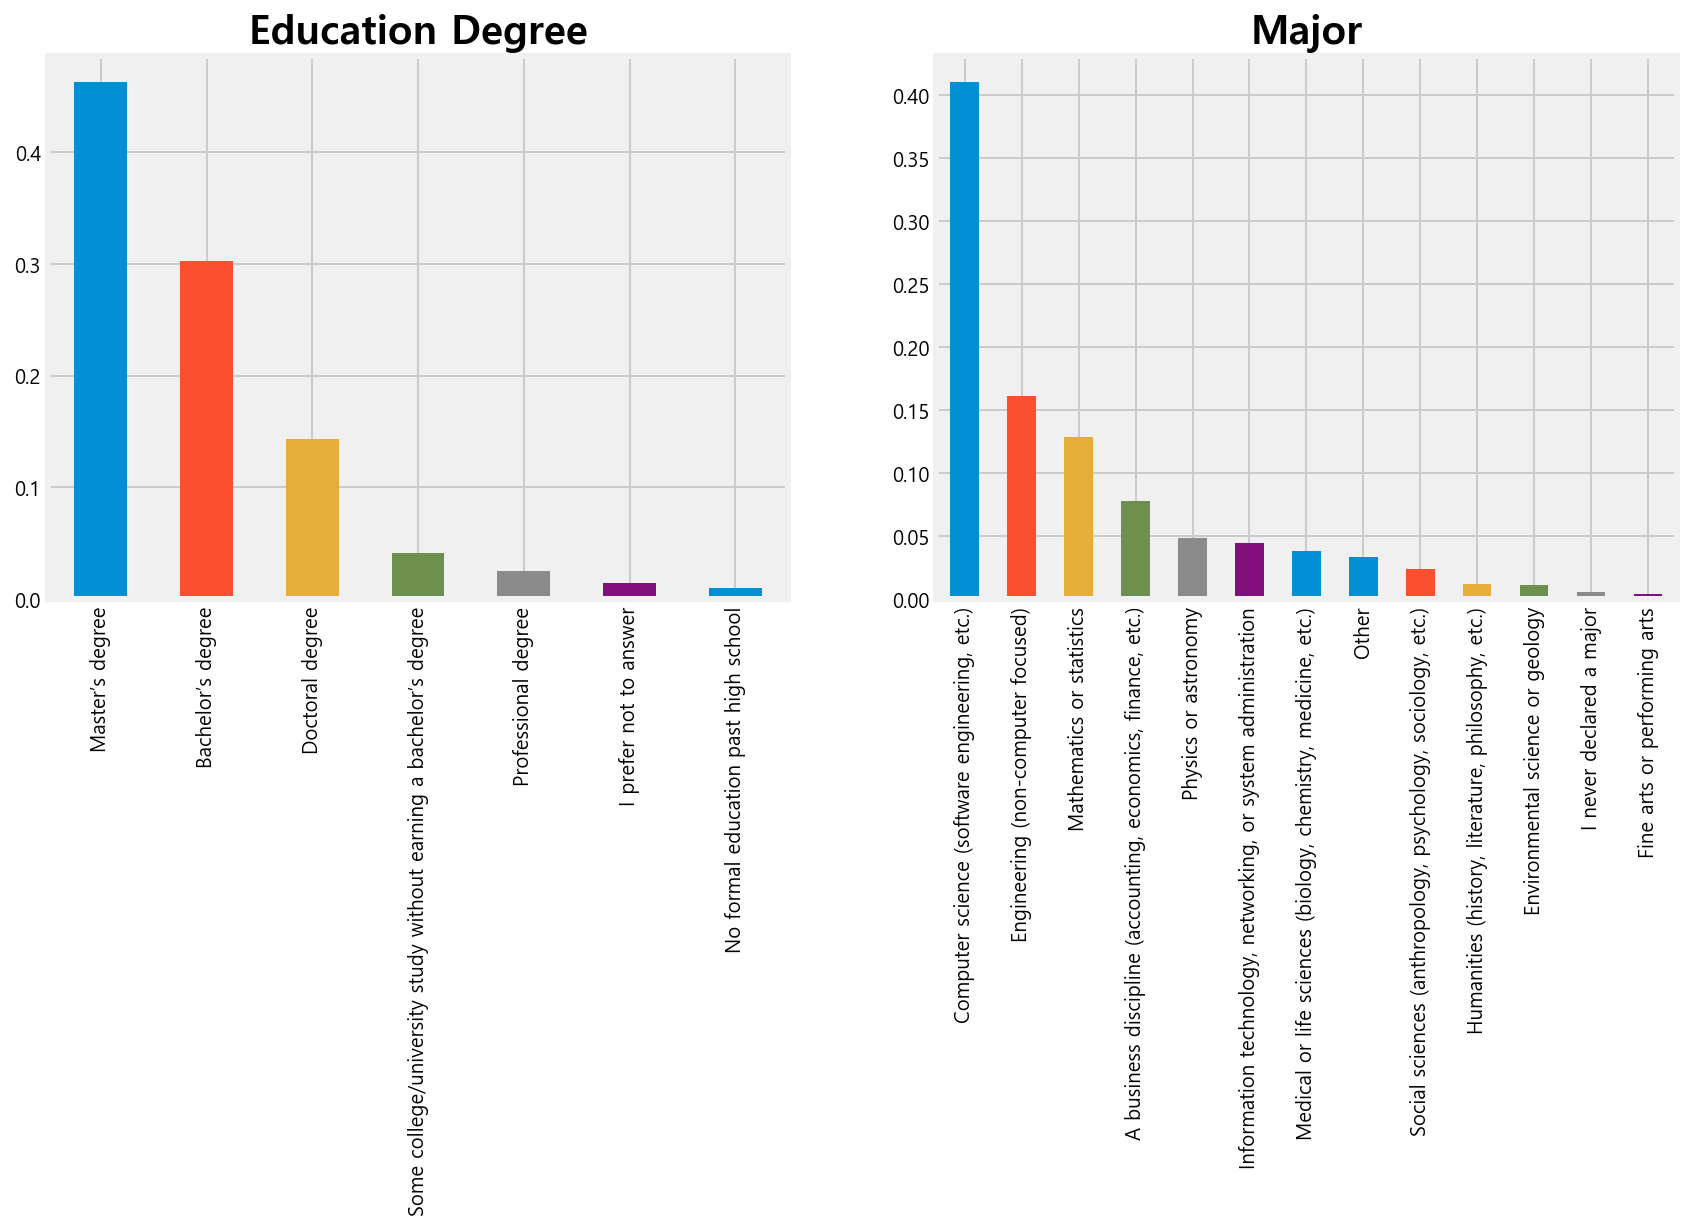

In [8]:
f, ax = plt.subplots(1,2,figsize=(13,5))
per_df('Q4').sort_values(ascending=False).plot.bar(ax=ax[0]).set_title('Education Degree', fontdict=fontdict)
per_df('Q5').plot.bar(ax=ax[1]).set_title('Major', fontdict=fontdict)

Text(0.5,1,'Industry')

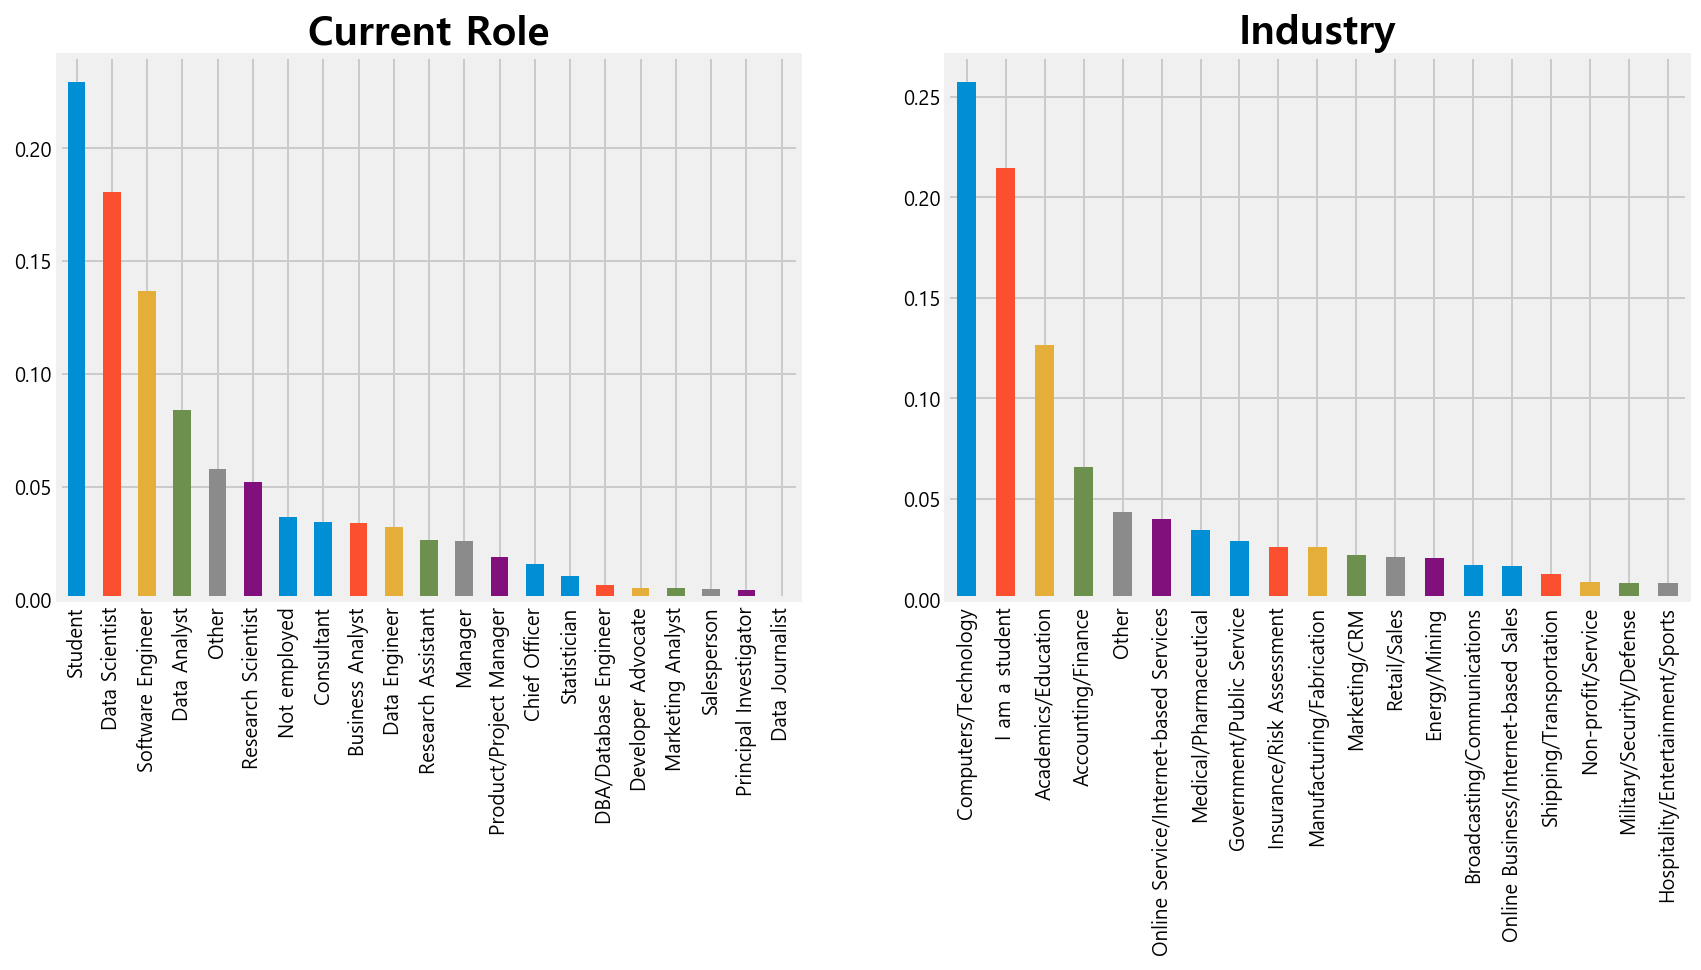

In [9]:
f, ax = plt.subplots(1,2,figsize=(13,5))
per_df('Q6').sort_values(ascending=False).plot.bar(ax=ax[0]).set_title('Current Role', fontdict=fontdict)
per_df('Q7').plot.bar(ax=ax[1]).set_title('Industry', fontdict=fontdict)

Text(0.5,1,'Compensation')

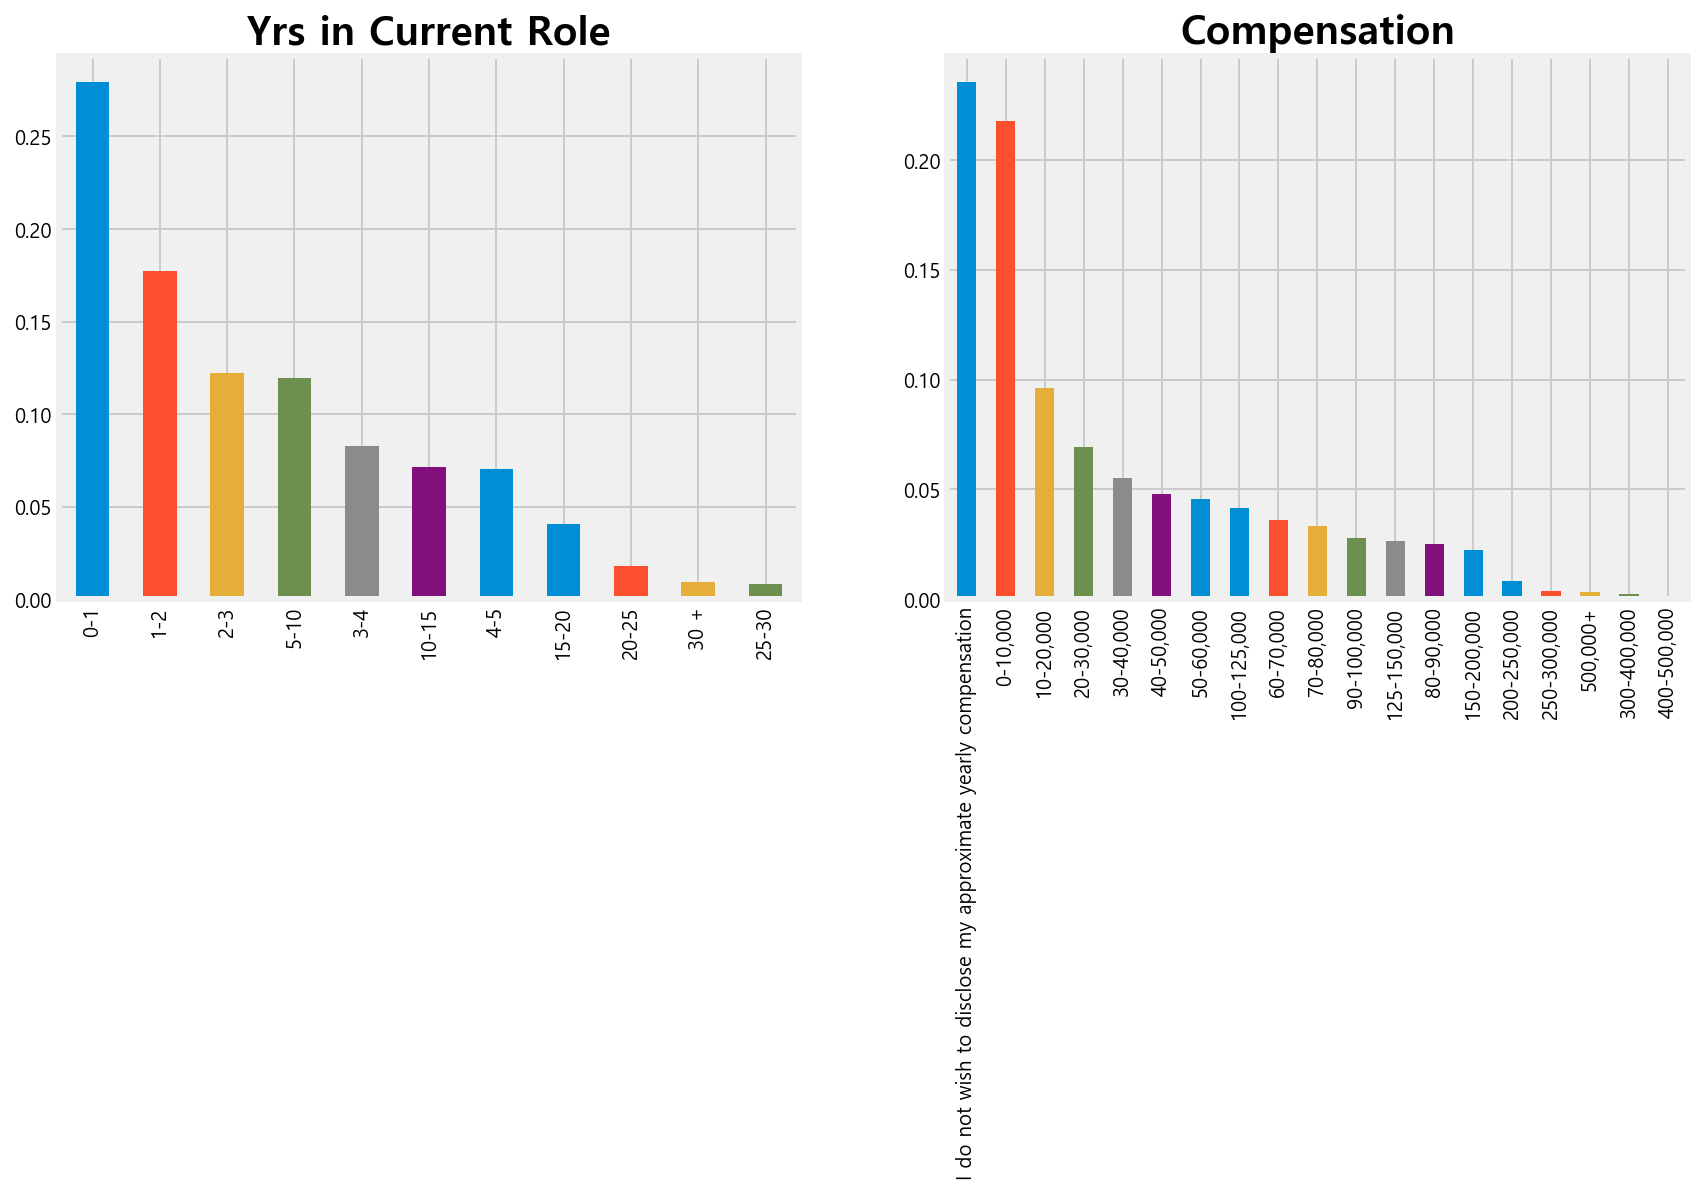

In [10]:
f, ax = plt.subplots(1,2,figsize=(13,5))
per_df('Q8').sort_values(ascending=False).plot.bar(ax=ax[0]).set_title('Yrs in Current Role', fontdict=fontdict)
per_df('Q9').plot.bar(ax=ax[1]).set_title('Compensation', fontdict=fontdict)

Text(0.5,1,'Using machine learning in company')

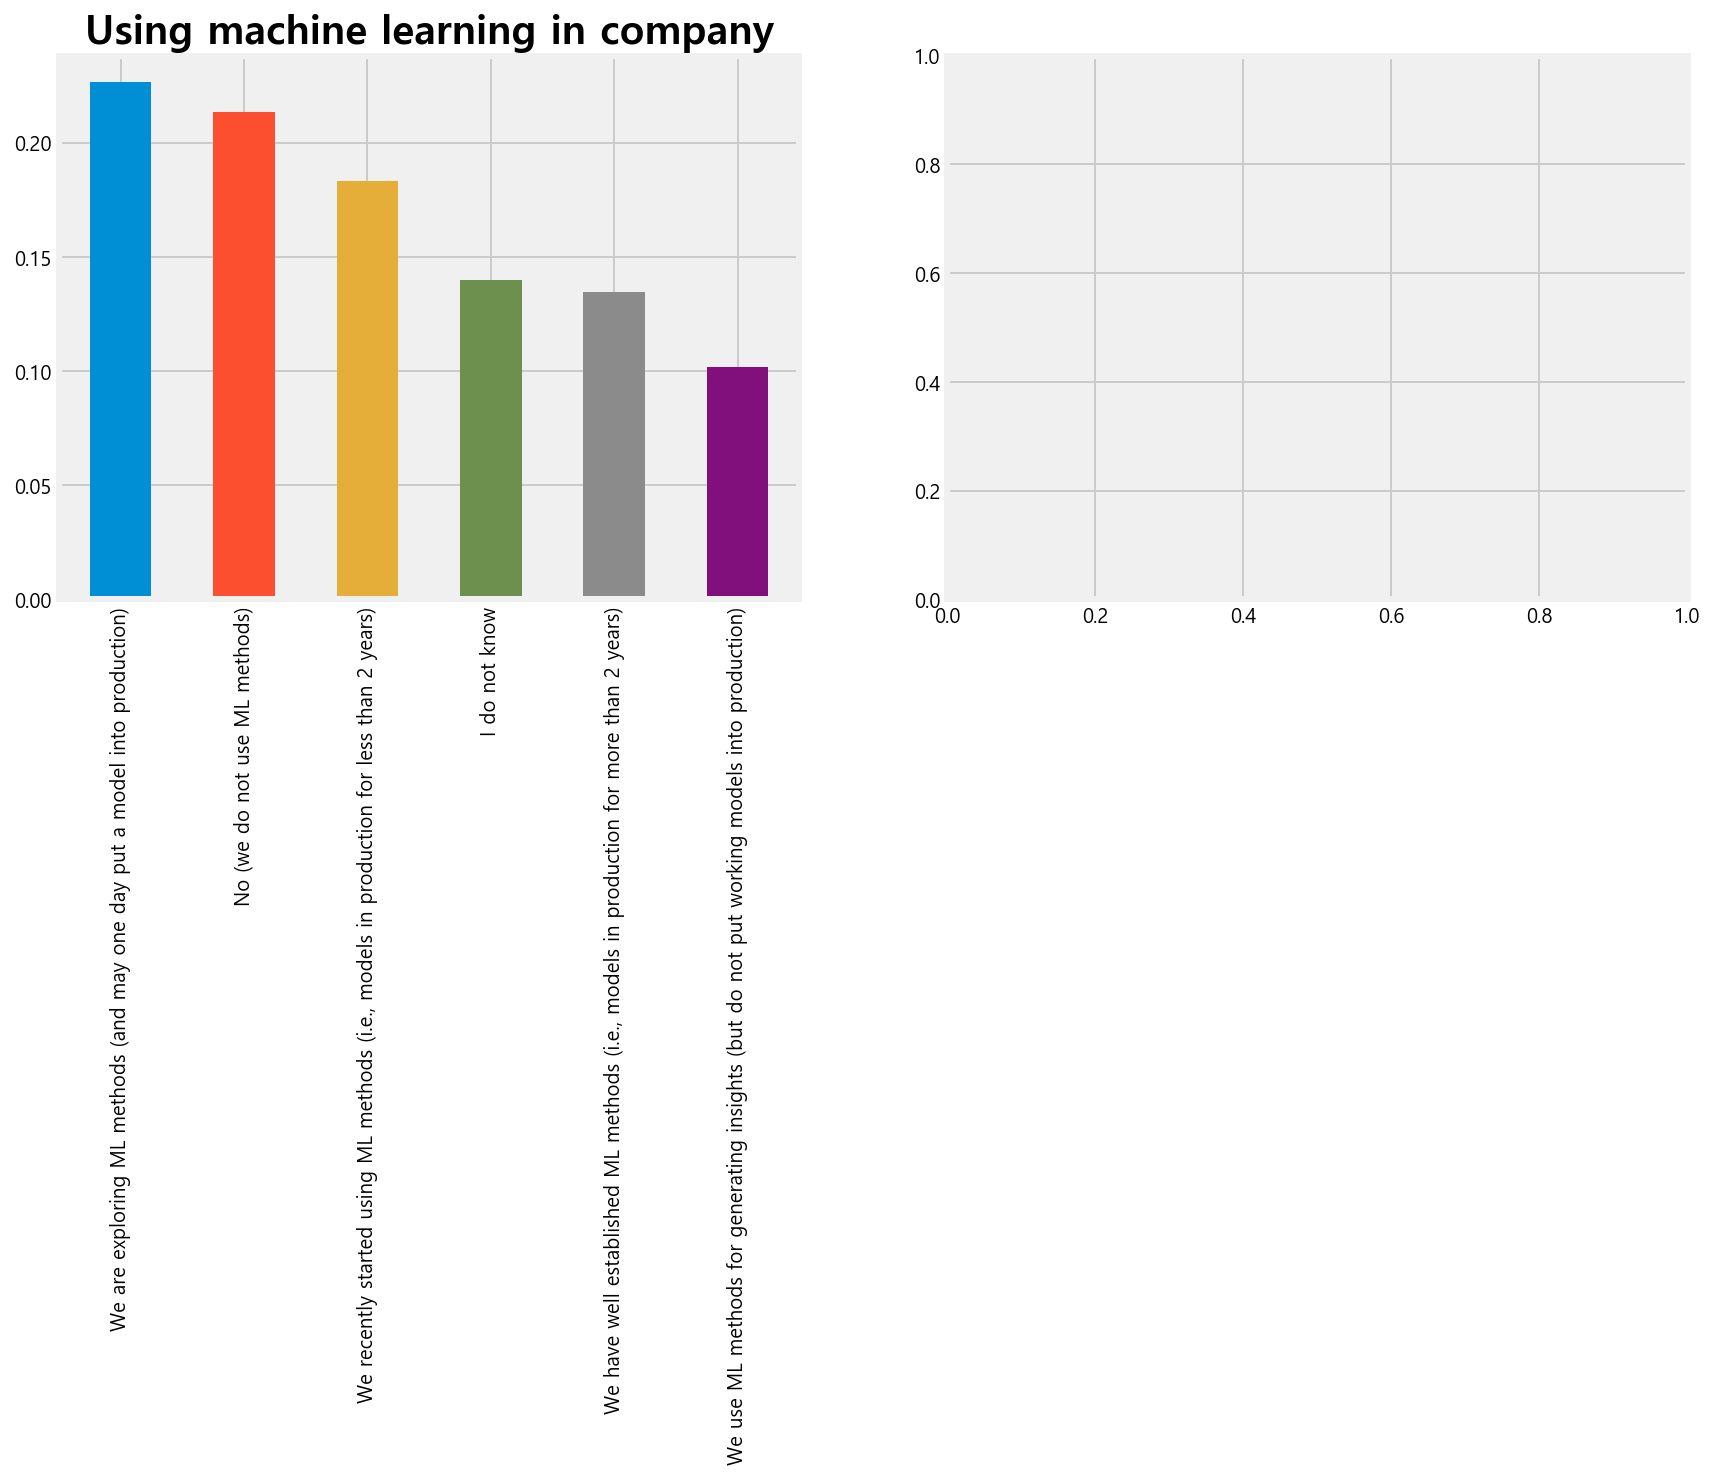

In [11]:
f, ax = plt.subplots(1,2,figsize=(13,5))
per_df('Q10').sort_values(ascending=False).plot.bar(ax=ax[0]).set_title('Using machine learning in company', fontdict=fontdict)

In [12]:
b_list = []
for a in [c for c in qn_list if 'Select any' in c] :
    b = a.split('- ')[-1]
    b_list.append(b)    

Text(0.5,1,'Which is your IDE')

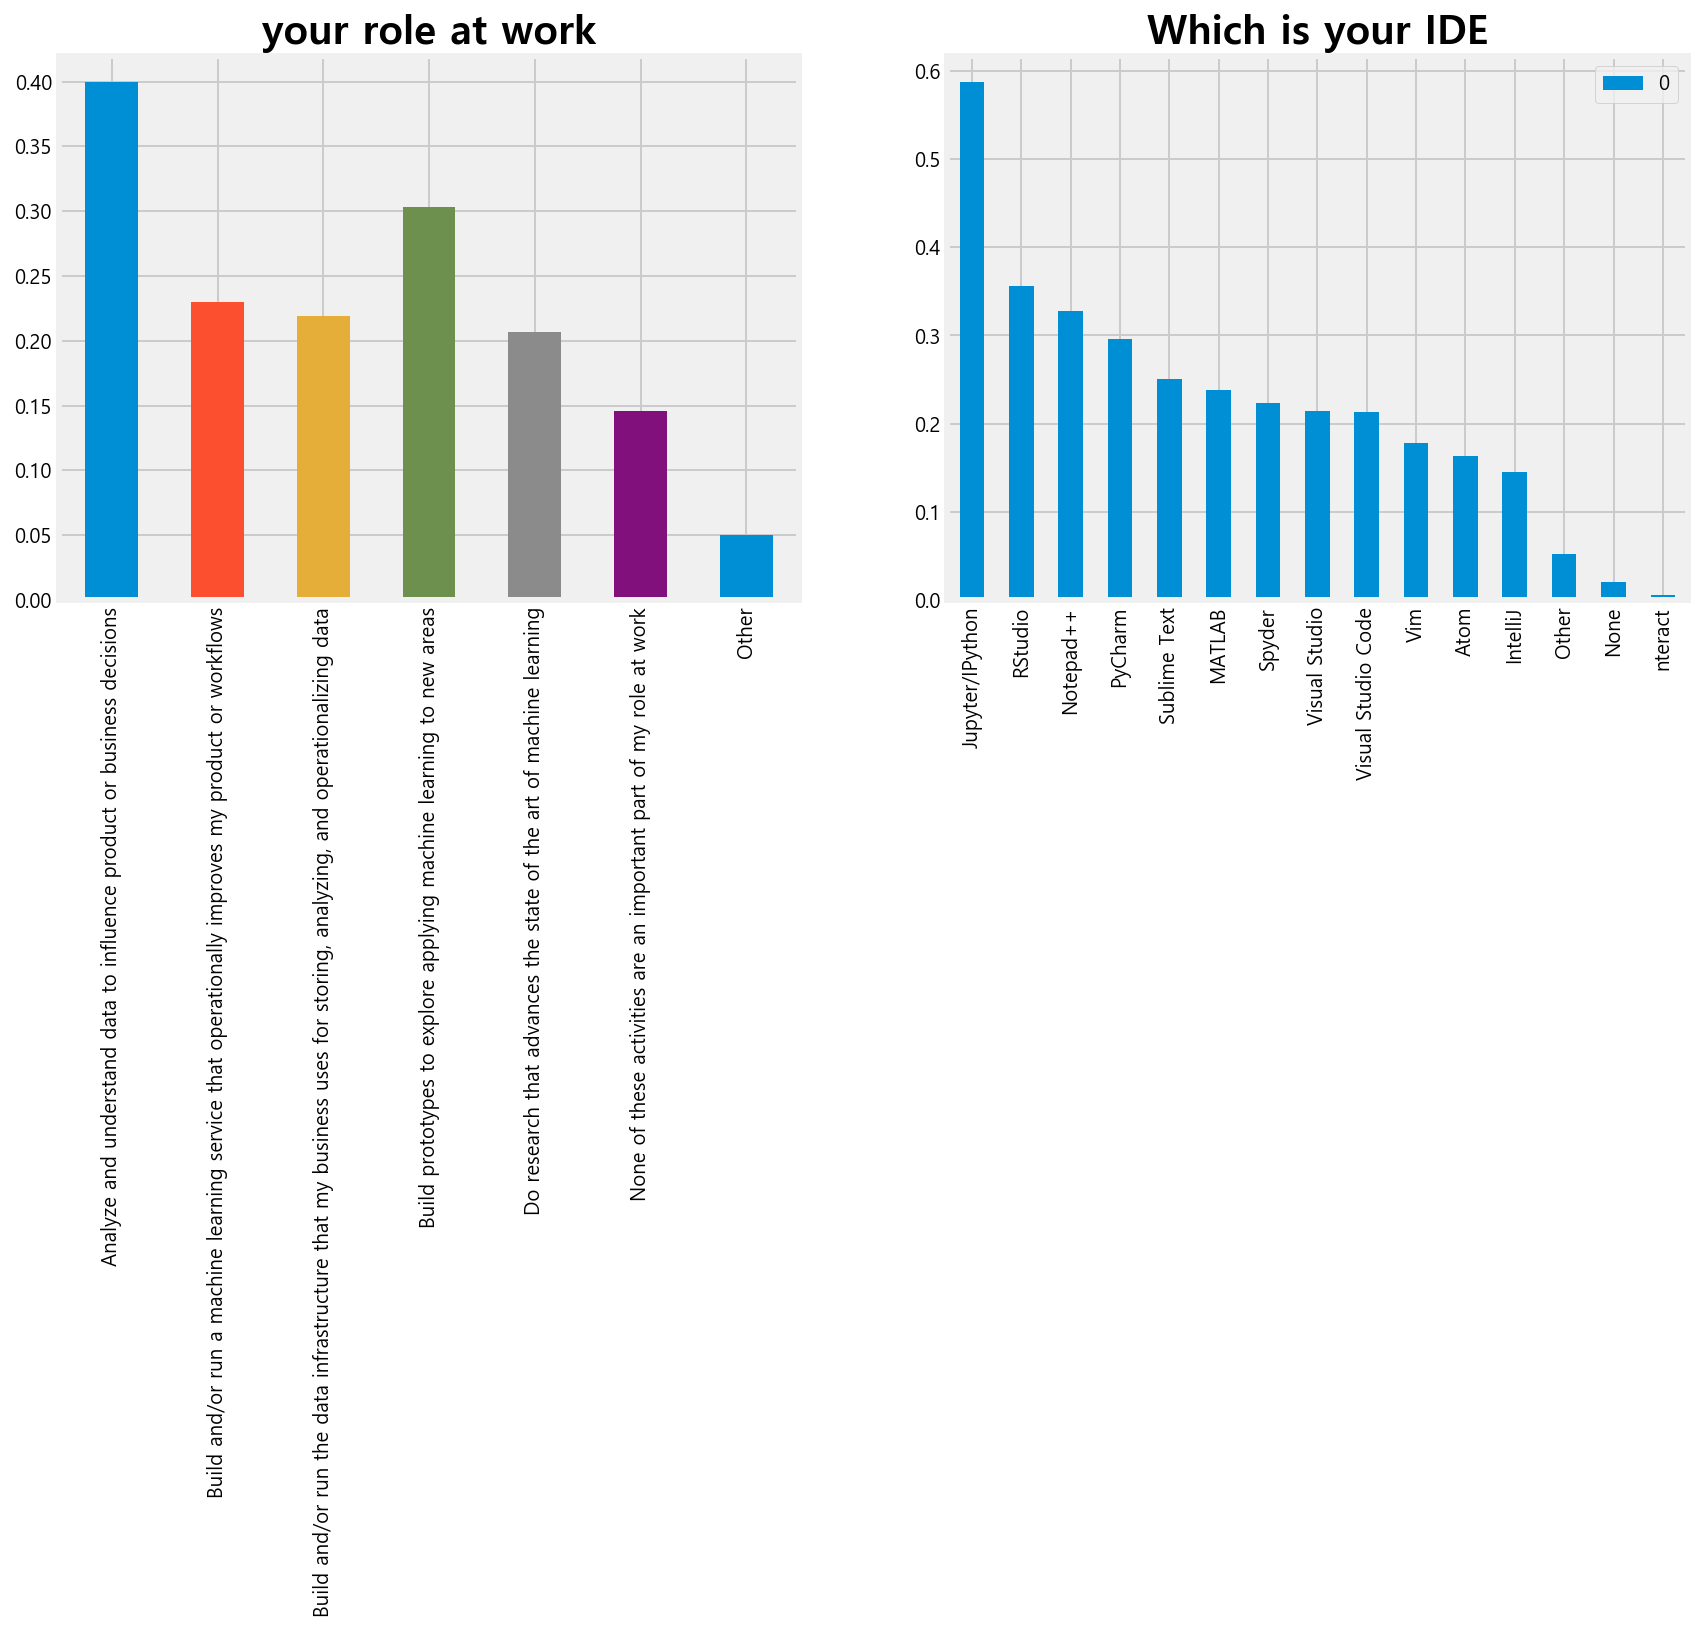

In [13]:
f, ax =plt.subplots(1,2,figsize=(13,5))
col = [ c for c in survey_multi.columns if 'Q11_Part' in c]
part_qn = survey_multi[col]
part_qn_binary = part_qn.fillna(0).replace('[^\\d]',1, regex=True)
g = (part_qn_binary.sum() / part_qn_binary.count()).plot.bar(ax=ax[0])
g.set_xticklabels(b_list)
g.set_title('your role at work', fontdict=fontdict)

# 13번 질문 하는 법 (어떤 IDE 쓰는지)
ide_qn_list =[c for c in qn_list if 'IDE' in c]
b_list = []
for a in ide_qn_list :
    b = a.split('- ')
    b_list.append(b[-1])    
    
col2 = [ c for c in survey_multi.columns if 'Q13_Part' in c]
ide_qs = survey_multi[col2]
ide_qs_binary = ide_qs.fillna(0).replace('[^\\d]',1, regex=True)

Q13_df = pd.DataFrame((ide_qs_binary.sum() / ide_qs_binary.count()))
Q13_df.index=b_list[:-1]

g = Q13_df.sort_values(by=0,ascending=False).plot.bar(ax=ax[1])
g.set_title('Which is your IDE', fontdict=fontdict)

Text(0.5,1,'Following hosted notebooks')

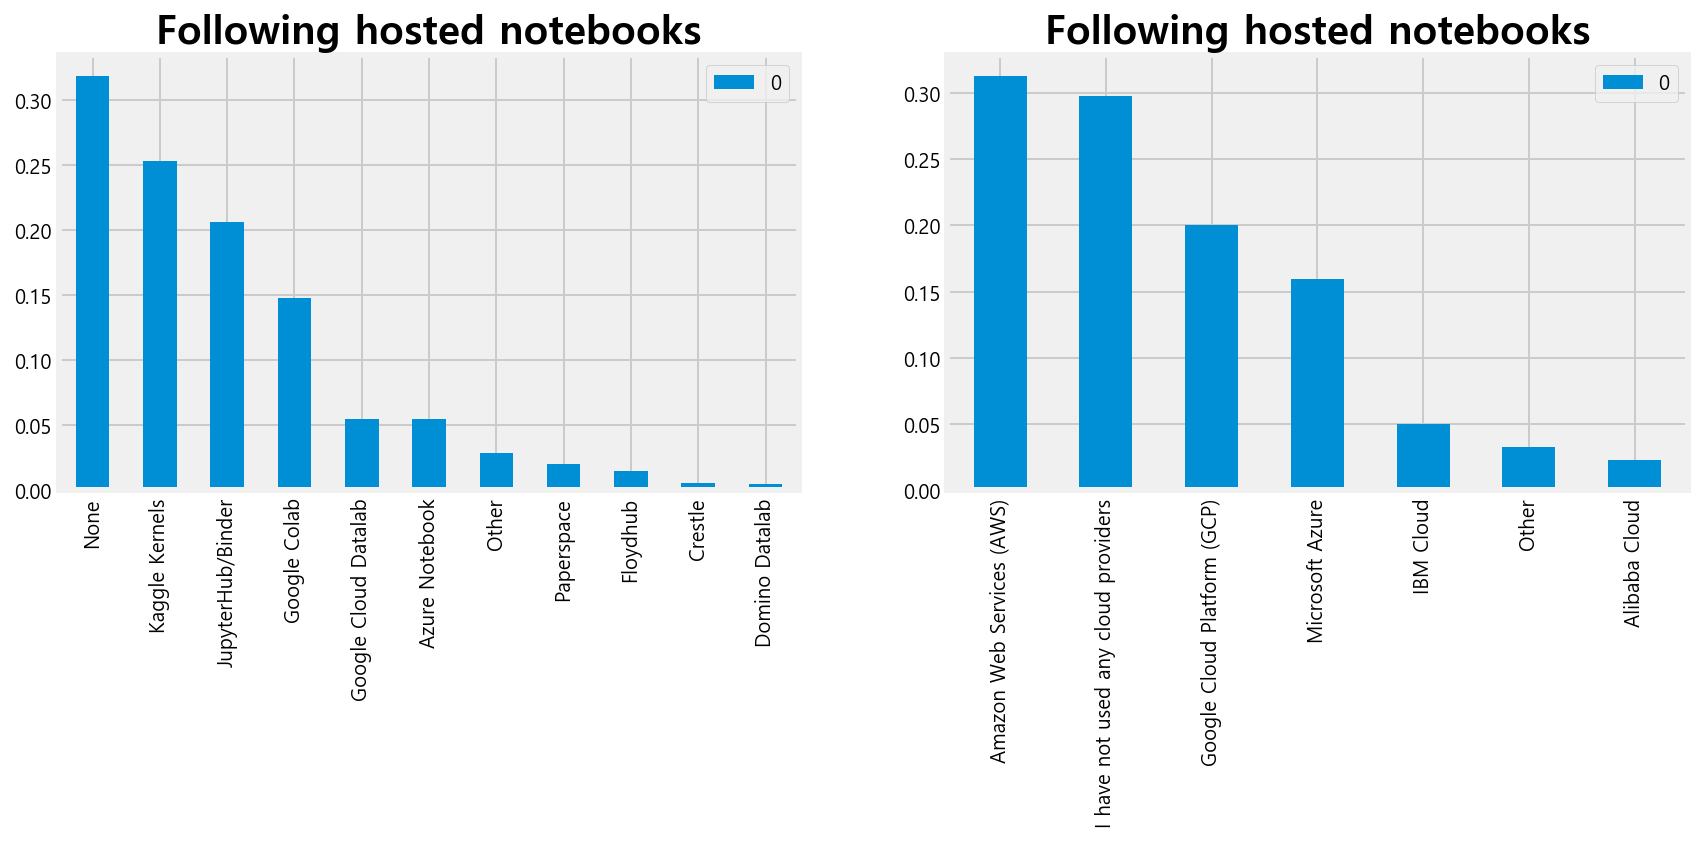

In [14]:
f, ax = plt.subplots(1,2,figsize=(13,4))
ide_qn_list =[c for c in qn_list if 'hosted notebooks' in c]
b_list = []
for a in ide_qn_list :
    b = a.split('- ')
    b_list.append(b[-1])   
    
col2 = [ c for c in survey_multi.columns if 'Q14_Part' in c]
ide_qs = survey_multi[col2]
ide_qs_binary = ide_qs.fillna(0).replace('[^\\d]',1, regex=True)

Q14_df = pd.DataFrame((ide_qs_binary.sum() / ide_qs_binary.count()))
Q14_df.index=b_list[:-1]

g = Q14_df.sort_values(by=0,ascending=False).plot.bar(ax=ax[0])
g.set_title('Following hosted notebooks', fontdict=fontdict)

ide_qn_list =[c for c in qn_list if 'cloud computing service' in c]
b_list = []
for a in ide_qn_list :
    b = a.split('- ')
    b_list.append(b[-1])   
    
col2 = [ c for c in survey_multi.columns if 'Q15_Part' in c]
ide_qs = survey_multi[col2]
ide_qs_binary = ide_qs.fillna(0).replace('[^\\d]',1, regex=True)

Q15_df = pd.DataFrame((ide_qs_binary.sum() / ide_qs_binary.count()))
Q15_df.index=b_list[:-1]

g = Q15_df.sort_values(by=0,ascending=False).plot.bar(ax=ax[1])
g.set_title('Following hosted notebooks', fontdict=fontdict)

Text(0.5,1,'Machine learning framework')

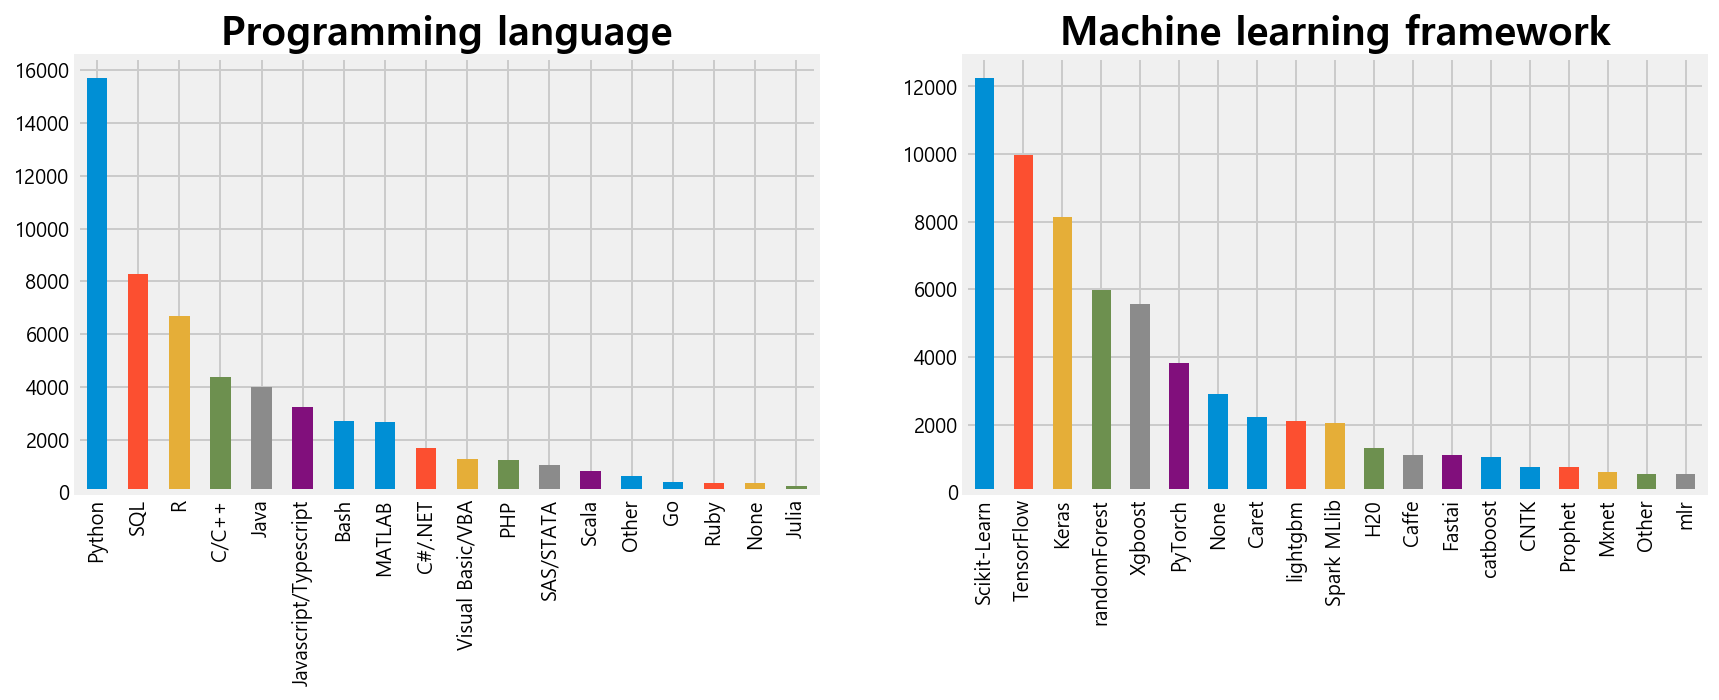

In [15]:
f, ax = plt.subplots(1,2,figsize=(13,4))
cols = [c for c in survey_multi.columns if 'Q16_Part' in c]
list_of_pl = survey_multi[cols].values.ravel().tolist()
list_of_pl = pd.Series([ide for ide in list_of_pl if isinstance(ide, str)])
pl_counts = list_of_pl.value_counts()

g = pl_counts.plot.bar(ax=ax[0])
g.set_title('Programming language', fontdict=fontdict)


cols = [c for c in survey_multi.columns if 'Q19_Part' in c]
list_of_pl = survey_multi[cols].values.ravel().tolist()
list_of_pl = pd.Series([ide for ide in list_of_pl if isinstance(ide, str)])
pl_counts = list_of_pl.value_counts()
g = pl_counts.plot.bar(ax=ax[1])
g.set_title('Machine learning framework', fontdict=fontdict)